## Importing Libraries and Tools

In [1]:

# from matplotlib import style
# %matplotlib inline
# plt.style.use('ggplot')
# import scipy.stats as stats
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# from statsmodels.formula.api import ols
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
# from sklearn.pipeline import make_pipeline
# from sklearn.pipeline import make_pipeline as make_pipeline_imb
# import statsmodels.stats.api as sms


import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import pandas as pd
import numpy as np
from numpy import where
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced
# from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from collections import Counter

import xgboost as xgb

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## Importing CSV from Kaggle

In [2]:
# https://www.kaggle.com/becksddf/churn-in-telecoms-dataset

df = pd.read_csv(('bigml_59c28831336c6604c800002a.csv'), index_col = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3333 entries, KS to TN
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account length          3333 non-null   int64  
 1   area code               3333 non-null   int64  
 2   phone number            3333 non-null   object 
 3   international plan      3333 non-null   object 
 4   voice mail plan         3333 non-null   object 
 5   number vmail messages   3333 non-null   int64  
 6   total day minutes       3333 non-null   float64
 7   total day calls         3333 non-null   int64  
 8   total day charge        3333 non-null   float64
 9   total eve minutes       3333 non-null   float64
 10  total eve calls         3333 non-null   int64  
 11  total eve charge        3333 non-null   float64
 12  total night minutes     3333 non-null   float64
 13  total night calls       3333 non-null   int64  
 14  total night charge      3333 non-null   float6

## Introduction

During this project, I want to understand what factors are most important in understanding how to retain a customer with Telecom based on this CSV file. The features are pretty understandable so I won't go into depth on describing them.

My predictor to these models, I will be using the 'churn' feature. This feature states whether or not the customer stayed or left the phone carrier.

Questions to answer during project:

  1) How heavily will customer service calls effect if a customer stays or leaves the provider?
  2) Will higher account length retain the customer better?
  3) What is the most accurate model at predicting accurately if a customer is churned or not.

## EDA/Cleaning

In [3]:
# Dropping irrelevent information to model. 
# This information will not help predict if a customer is retained or not.

df = df.drop('area code', 1)
df = df.drop('phone number', 1)

In [4]:
# There is a distinct imbalance that needs to be addressed during the training section of Train-Test Split. 
# The model would unfairly have a high accuracy score of predicting false
# but poorly predict accuracy of new data entering the model.

df['churn'].value_counts()

False    2850
True      483
Name: churn, dtype: int64

### Dummy Variable Creation

In [5]:
# Creating dummy variables for three columns that were either True/False or Yes/No

international_plan = pd.get_dummies(df['international plan'], prefix = 'international plan', drop_first = True)
voice_mail_plan = pd.get_dummies(df['voice mail plan'], prefix = 'voice mail plan', drop_first = True)
churned = pd.get_dummies(df['churn'], prefix = 'churn', drop_first = True)

In [6]:
international_plan.columns = [column.replace('.', '_') for column in international_plan.columns]

In [7]:
voice_mail_plan.columns = [column.replace('.', '_') for column in voice_mail_plan.columns]

In [8]:
churned.columns = [column.replace('.', '_') for column in churned.columns]

In [9]:
voice_mail_plan.columns

Index(['voice mail plan_yes'], dtype='object')

In [10]:
international_plan = international_plan.astype(str).astype(float)
voice_mail_plan = voice_mail_plan.astype(str).astype(float)
churned = churned.astype(str).astype(float)

In [11]:
# Verifying international plan_yes and the others changed their Dtype
# to effectively utilize predictive modeling later on

international_plan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3333 entries, KS to TN
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   international plan_yes  3333 non-null   float64
dtypes: float64(1)
memory usage: 52.1+ KB


In [12]:
# Adding and subtracting dummy columns and columns that they represented

df = pd.concat([df, international_plan, voice_mail_plan, churned], axis = 1)
df

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,...,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn,international plan_yes,voice mail plan_yes,churn_True
state,,,,,,,,,,,,,,,,,,,,,
KS,128,no,yes,25,265.1,110,45.07,197.4,99,16.78,...,91,11.01,10.0,3,2.70,1,False,0.0,1.0,0.0
OH,107,no,yes,26,161.6,123,27.47,195.5,103,16.62,...,103,11.45,13.7,3,3.70,1,False,0.0,1.0,0.0
NJ,137,no,no,0,243.4,114,41.38,121.2,110,10.30,...,104,7.32,12.2,5,3.29,0,False,0.0,0.0,0.0
OH,84,yes,no,0,299.4,71,50.90,61.9,88,5.26,...,89,8.86,6.6,7,1.78,2,False,1.0,0.0,0.0
OK,75,yes,no,0,166.7,113,28.34,148.3,122,12.61,...,121,8.41,10.1,3,2.73,3,False,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZ,192,no,yes,36,156.2,77,26.55,215.5,126,18.32,...,83,12.56,9.9,6,2.67,2,False,0.0,1.0,0.0
WV,68,no,no,0,231.1,57,39.29,153.4,55,13.04,...,123,8.61,9.6,4,2.59,3,False,0.0,0.0,0.0
RI,28,no,no,0,180.8,109,30.74,288.8,58,24.55,...,91,8.64,14.1,6,3.81,2,False,0.0,0.0,0.0


In [13]:
df = df.drop(['international plan', 'voice mail plan', 'churn'], axis=1)

In [14]:
df.head()

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,international plan_yes,voice mail plan_yes,churn_True
state,,,,,,,,,,,,,,,,,,
KS,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0.0,1.0,0.0
OH,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0.0,1.0,0.0
NJ,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0.0,0.0,0.0
OH,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,1.0,0.0,0.0
OK,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,1.0,0.0,0.0


### Exploratory Histograms

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb24c12f390>,
      dtype=object)

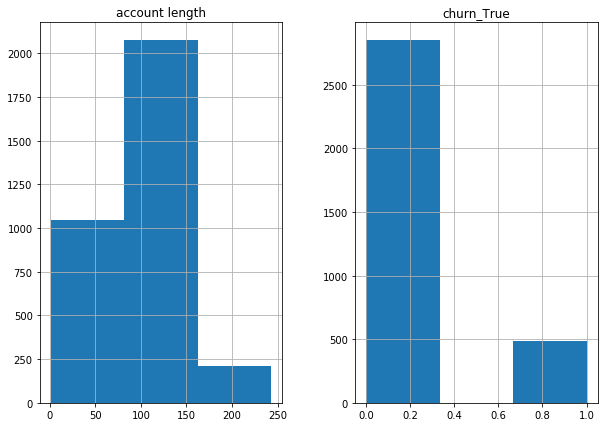

In [15]:
acct_length_vs_churn = ['account length', 'churn_True']
df[acct_length_vs_churn].hist(bins=3, figsize=(10, 7))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb24c221198>,
      dtype=object)

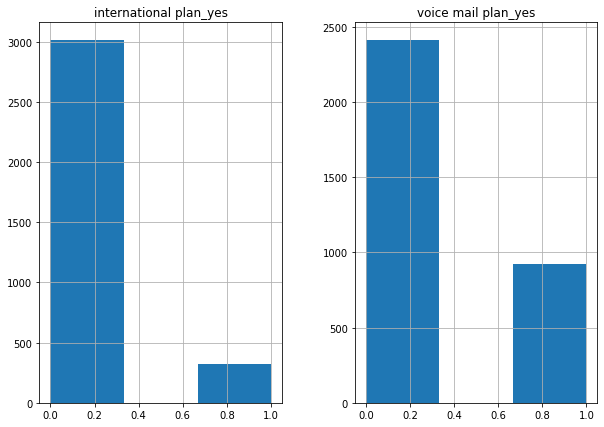

In [16]:
plans = ['international plan_yes', 'voice mail plan_yes']
df[plans].hist(bins=3, figsize=(10, 7))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb24c5b14e0>,
      dtype=object)

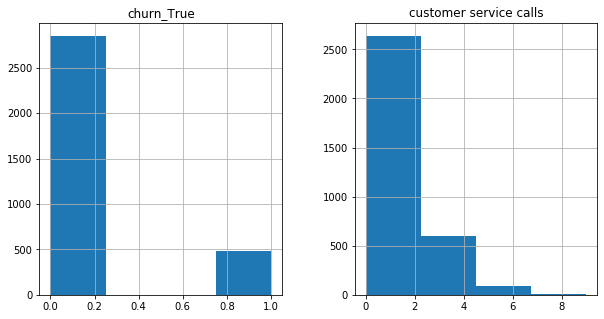

In [17]:
cs_call_vs_churn = ['customer service calls', 'churn_True']
df[cs_call_vs_churn].hist(bins=4, figsize=(10, 5))

In [18]:
total_minutes = ['total day minutes', 'total eve minutes', 'total night minutes', 'total intl minutes']
df[total_minutes].describe()

,total day minutes,total eve minutes,total night minutes,total intl minutes
count,3333.000000,3333.000000,3333.000000,3333.000000
mean,179.775098,200.980348,200.872037,10.237294
std,54.467389,50.713844,50.573847,2.791840
min,0.000000,0.000000,23.200000,0.000000
25%,143.700000,166.600000,167.000000,8.500000
50%,179.400000,201.400000,201.200000,10.300000
75%,216.400000,235.300000,235.300000,12.100000
max,350.800000,363.700000,395.000000,20.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb24c7b7f98>,
      dtype=object)

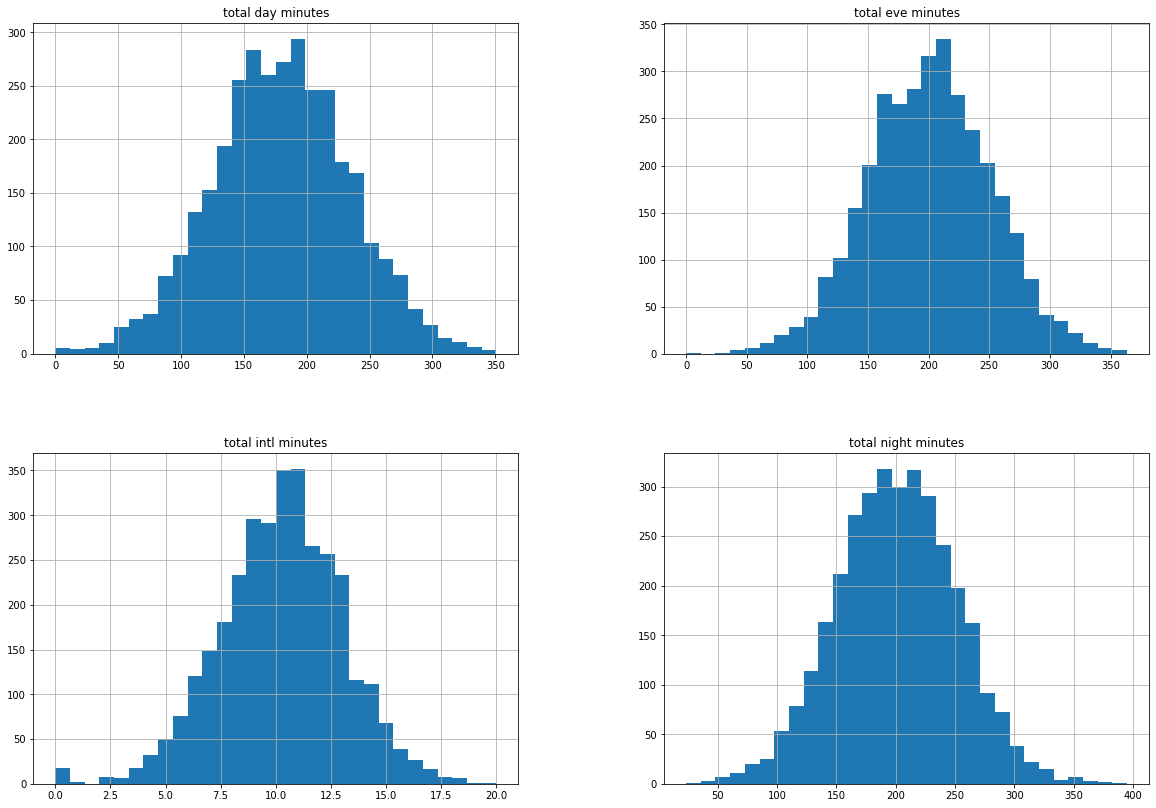

In [19]:
df[total_minutes].hist(bins=30, figsize=(20, 14))

In [20]:
# Observation: International calls are skewed to the right, meaning the mean of this feature is lower than the other three features.
# There's much fewer data representing international calls than its counter-parts.

total_calls = ['total day calls', 'total eve calls', 'total night calls', 'total intl calls']
df[total_calls].describe()

,total day calls,total eve calls,total night calls,total intl calls
count,3333.000000,3333.000000,3333.000000,3333.000000
mean,100.435644,100.114311,100.107711,4.479448
std,20.069084,19.922625,19.568609,2.461214
min,0.000000,0.000000,33.000000,0.000000
25%,87.000000,87.000000,87.000000,3.000000
50%,101.000000,100.000000,100.000000,4.000000
75%,114.000000,114.000000,113.000000,6.000000
max,165.000000,170.000000,175.000000,20.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb24d0fa358>,
      dtype=object)

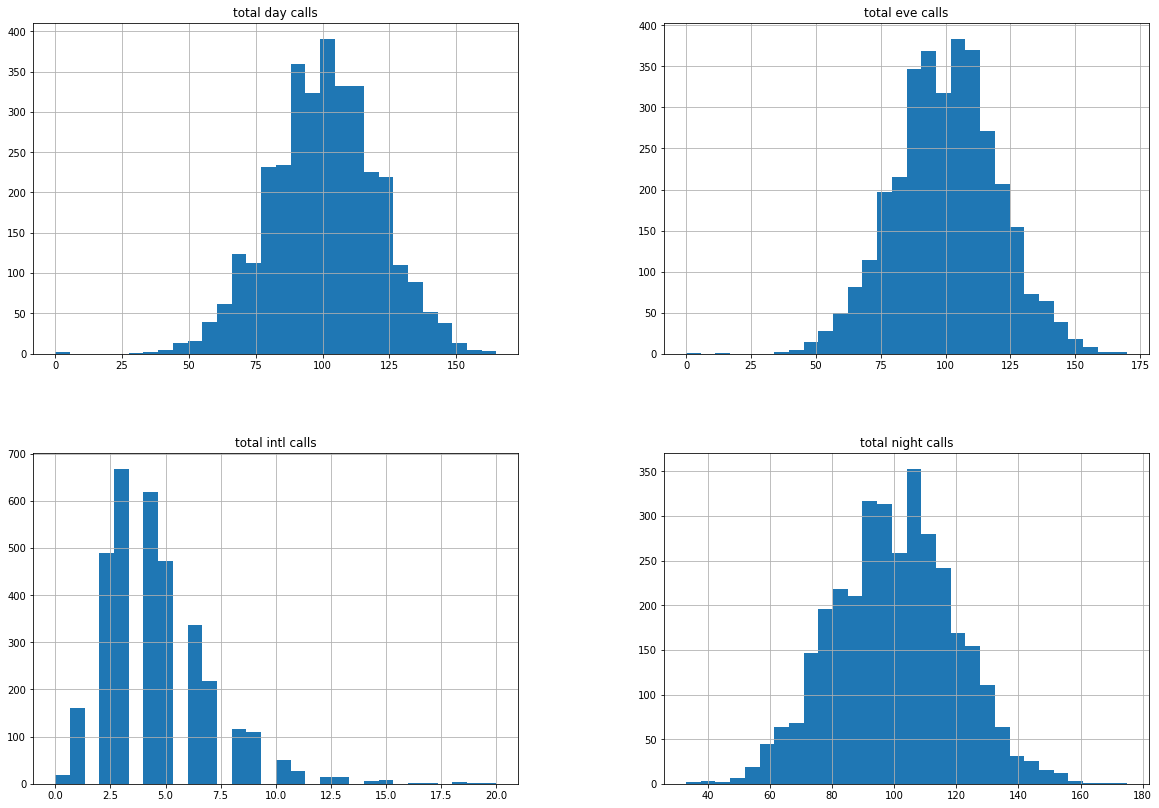

In [21]:
df[total_calls].hist(bins=30, figsize=(20, 14))

In [22]:
# Observation: normal distributions within these features
total_charges = ['total day charge', 'total eve charge', 'total night charge', 'total intl charge']
df[total_charges].describe()

,total day charge,total eve charge,total night charge,total intl charge
count,3333.000000,3333.000000,3333.000000,3333.000000
mean,30.562307,17.083540,9.039325,2.764581
std,9.259435,4.310668,2.275873,0.753773
min,0.000000,0.000000,1.040000,0.000000
25%,24.430000,14.160000,7.520000,2.300000
50%,30.500000,17.120000,9.050000,2.780000
75%,36.790000,20.000000,10.590000,3.270000
max,59.640000,30.910000,17.770000,5.400000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb24d723978>,
      dtype=object)

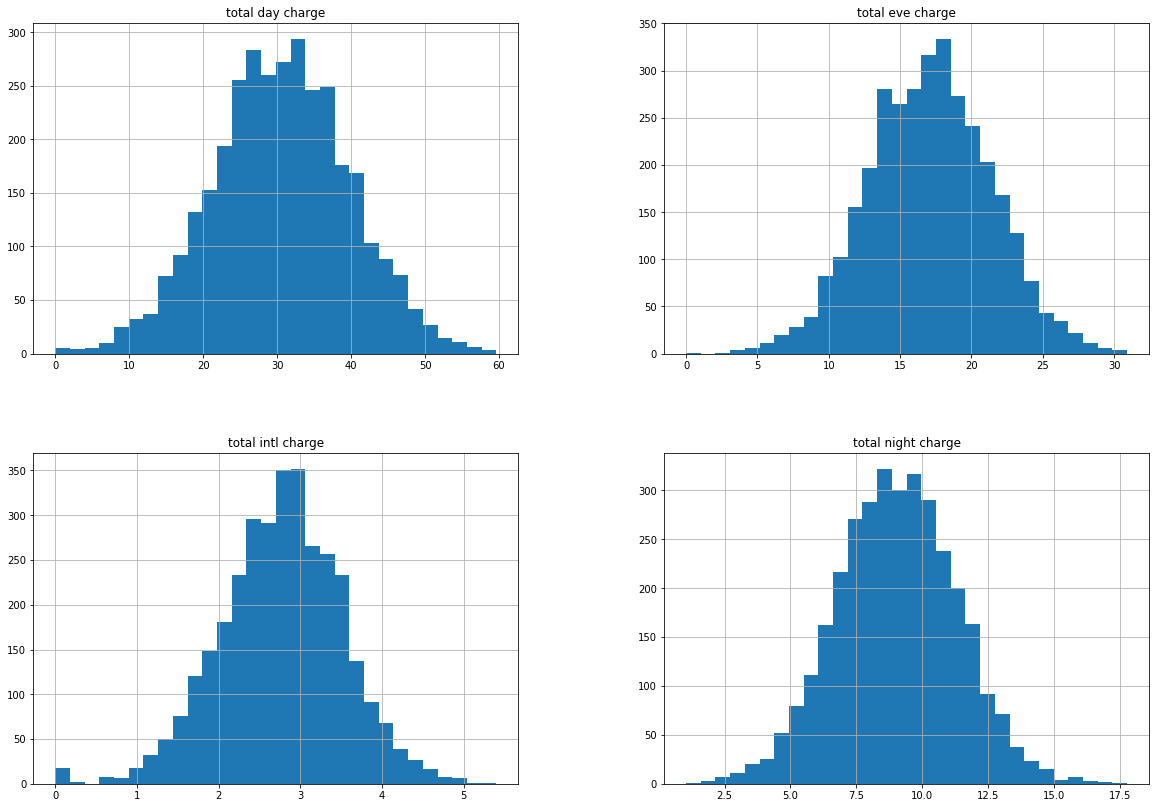

In [23]:
df[total_charges].hist(bins=30, figsize=(20, 14))

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

### Scatter Matrix

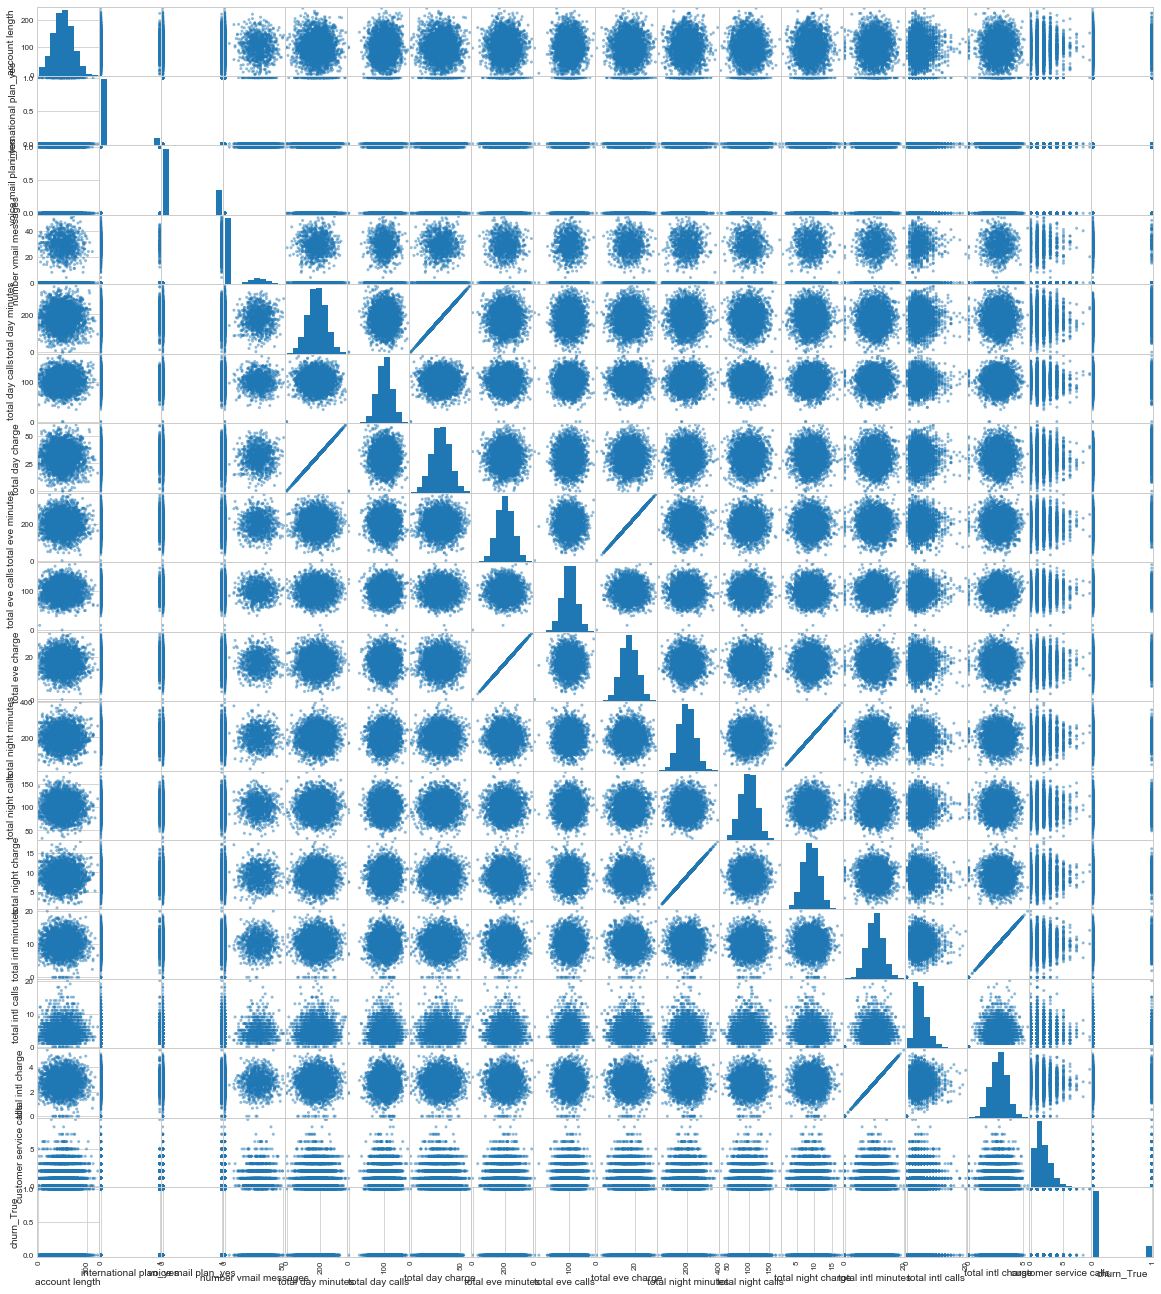

In [25]:
x_cols = ['account length', 'international plan_yes', 'voice mail plan_yes', 
          'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 
          'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 
          'total night calls', 'total night charge', 'total intl minutes', 'total intl calls', 
          'total intl charge', 'customer service calls', 'churn_True']

pd.plotting.scatter_matrix(df[x_cols], figsize=(20,23));


### Boxplot Analysis

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,international plan_yes,voice mail plan_yes,churn_True
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.096910,0.276628,0.144914
std,39.822106,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.295879,0.447398,0.352067
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000,0.000000,0.000000
50%,101.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,0.000000,0.000000,0.000000
75%,127.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,0.000000,1.000000,0.000000
max,243.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000,1.000000,1.000000


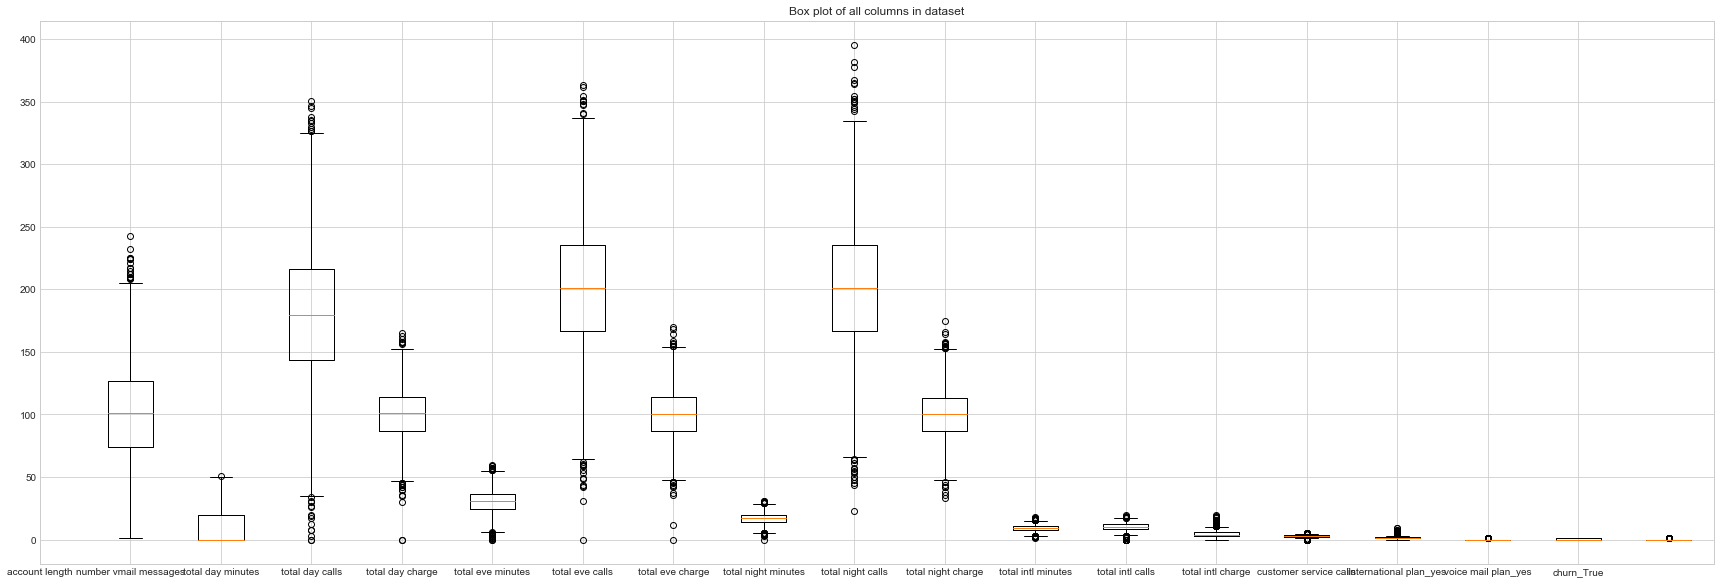

In [26]:
# Explore the dataset
display(df.describe())

# Create a box plot of each column
plt.figure(figsize=(30, 10))
plt.boxplot([df[col] for col in df.columns])
plt.title("Box plot of all columns in dataset")
plt.xticks(range(len(df.columns.values)), df.columns.values)
plt.show()

### Heatmap

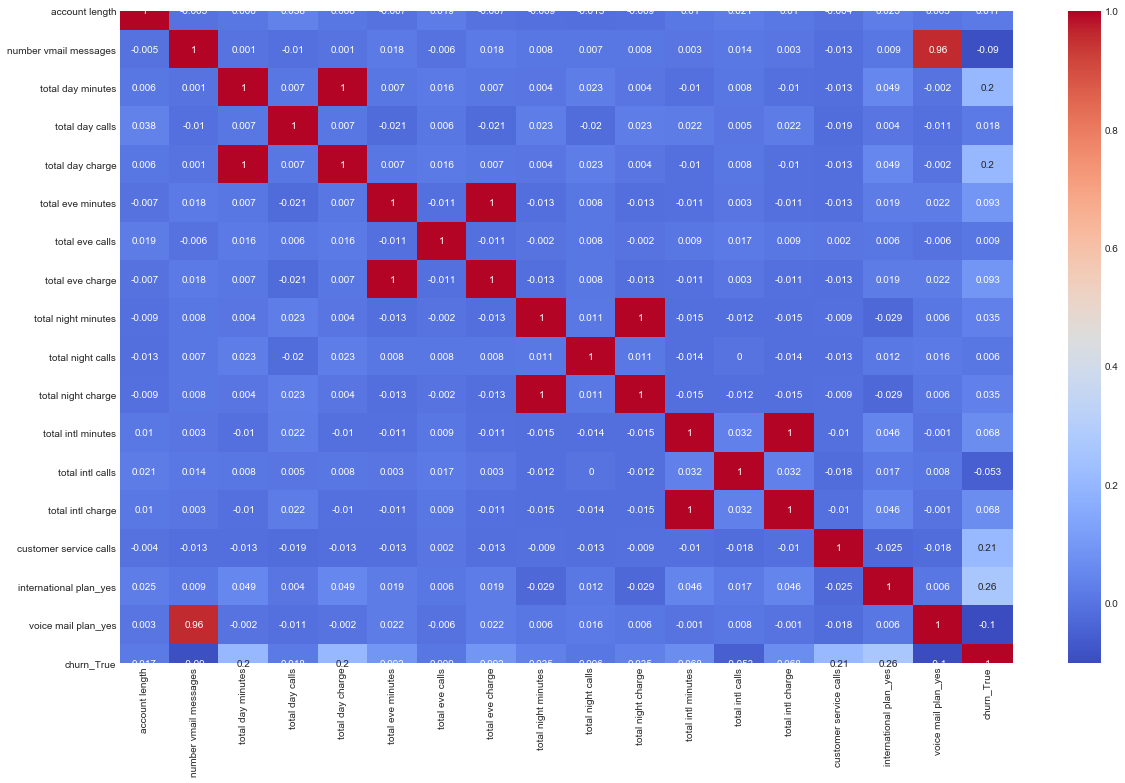

In [27]:
cor = df.corr()
plt.figure(figsize=(20,12))
sns.heatmap(cor.round(3),annot=True,cmap='coolwarm')
plt.show()

In [28]:
df.corr()

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,international plan_yes,voice mail plan_yes,churn_True
account length,1.000000,-0.004628,0.006216,0.038470,0.006214,-0.006757,0.019260,-0.006745,-0.008955,-0.013176,-0.008960,0.009514,0.020661,0.009546,-0.003796,0.024735,0.002918,0.016541
number vmail messages,-0.004628,1.000000,0.000778,-0.009548,0.000776,0.017562,-0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884,-0.013263,0.008745,0.956927,-0.089728
total day minutes,0.006216,0.000778,1.000000,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,0.004300,-0.010155,0.008033,-0.010092,-0.013423,0.049396,-0.001684,0.205151
total day calls,0.038470,-0.009548,0.006750,1.000000,0.006753,-0.021451,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.004574,0.021666,-0.018942,0.003755,-0.011086,0.018459
total day charge,0.006214,0.000776,1.000000,0.006753,1.000000,0.007050,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,0.008032,-0.010094,-0.013427,0.049398,-0.001686,0.205151
total eve minutes,-0.006757,0.017562,0.007043,-0.021451,0.007050,1.000000,-0.011430,1.000000,-0.012584,0.007586,-0.012593,-0.011035,0.002541,-0.011067,-0.012985,0.019100,0.021545,0.092796
total eve calls,0.019260,-0.005864,0.015769,0.006462,0.015769,-0.011430,1.000000,-0.011423,-0.002093,0.007710,-0.002056,0.008703,0.017434,0.008674,0.002423,0.006114,-0.006444,0.009233
total eve charge,-0.006745,0.017578,0.007029,-0.021449,0.007036,1.000000,-0.011423,1.000000,-0.012592,0.007596,-0.012601,-0.011043,0.002541,-0.011074,-0.012987,0.019106,0.021559,0.092786
total night minutes,-0.008955,0.007681,0.004323,0.022938,0.004324,-0.012584,-0.002093,-0.012592,1.000000,0.011204,0.999999,-0.015207,-0.012353,-0.015180,-0.009288,-0.028905,0.006079,0.035493
total night calls,-0.013176,0.007123,0.022972,-0.019557,0.022972,0.007586,0.007710,0.007596,0.011204,1.000000,0.011188,-0.013605,0.000305,-0.013630,-0.012802,0.012451,0.015553,0.006141


### Chi Squared Test

This test is used to compare the distribution of categories in a categorical feature of two or more groups; comparing if an attribute has a relationship to another categorical attribute.

In [29]:
df.columns

Index(['account length', 'number vmail messages', 'total day minutes',
       'total day calls', 'total day charge', 'total eve minutes',
       'total eve calls', 'total eve charge', 'total night minutes',
       'total night calls', 'total night charge', 'total intl minutes',
       'total intl calls', 'total intl charge', 'customer service calls',
       'international plan_yes', 'voice mail plan_yes', 'churn_True'],
      dtype='object')

In [30]:
# I want to find out which categorical features are significant (pvalue < 0.05) to utilize in the 
# models for the future.

categories = ['international plan_yes', 'voice mail plan_yes']

y = df['churn_True']
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
for col in categories:
    xcat = LabelEncoder().fit_transform(df[col]).reshape(-1,1)
    cval,pval = chi2(xcat,y)
    print(col,pval)

international plan_yes [4.09173473e-46]
voice mail plan_yes [5.28486023e-07]


### ANOVA Test

ANOVA testing is utilized for comparing the distributions of numeric variables within two or more groups

In [31]:
df.columns

Index(['account length', 'number vmail messages', 'total day minutes',
       'total day calls', 'total day charge', 'total eve minutes',
       'total eve calls', 'total eve charge', 'total night minutes',
       'total night calls', 'total night charge', 'total intl minutes',
       'total intl calls', 'total intl charge', 'customer service calls',
       'international plan_yes', 'voice mail plan_yes', 'churn_True'],
      dtype='object')

In [32]:
numericals = ['account length', 'number vmail messages', 'total day minutes',
       'total day calls', 'total day charge', 'total eve minutes',
       'total eve calls', 'total eve charge', 'total night minutes',
       'total night calls', 'total night charge', 'total intl minutes',
       'total intl calls', 'total intl charge', 'customer service calls']
xnum = df[numericals]
y = df['churn_True']
from sklearn.feature_selection import f_classif
fval,pval = f_classif(xnum,y)
for i in range(len(numericals)):print(numericals[i],pval[i])

account length 0.33976000705720666
number vmail messages 2.1175218402696038e-07
total day minutes 5.300278227509361e-33
total day calls 0.28670102402211844
total day charge 5.30060595239102e-33
total eve minutes 8.011338561256927e-08
total eve calls 0.5941305829720491
total eve charge 8.036524227754477e-08
total night minutes 0.04046648463758881
total night calls 0.7230277872081609
total night charge 0.040451218769160205
total intl minutes 8.05731126549437e-05
total intl calls 0.002274701409850077
total intl charge 8.018753583047257e-05
customer service calls 3.900360240185746e-34


## Applying to ML algorithms

In [33]:
# Taking all significant features and consolodating them into the X-value with regards to my y-value

X = df[['total eve charge', 'total eve minutes', 'total day charge', 
       'number vmail messages', 'total day minutes', 'total night minutes', 
       'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 
       'international plan_yes', 'voice mail plan_yes']]
y = df['churn_True']

In [34]:
def print_results(headline, true_value, pred):
    print(headline)
    print('accuracy: {}'.format(accuracy_score(true_value, pred)))
    print('precision: {}'.format(precision_score(true_value, pred)))
    print('recall: {}'.format(recall_score(true_value, pred)))
    print('f1: {}'.format(f1_score(true_value, pred)))

In [35]:
# # splitting data into trainning and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=1)

#### SMOTE 

In [36]:
X = df[['total eve charge', 'total eve minutes', 'total day charge', 
       'number vmail messages', 'total day minutes', 'total night minutes', 
       'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 
       'international plan_yes', 'voice mail plan_yes']]
y = df['churn_True']

counter = Counter(y)
print(counter)

Counter({0.0: 2850, 1.0: 483})


Counter({0.0: 2850, 1.0: 483})
Counter({0.0: 2850, 1.0: 2850})


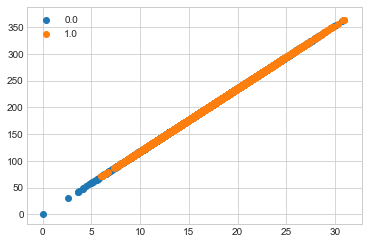

In [37]:
counter = Counter(y)
print(counter)

# Generating and plotting synthetic imbalanced classification dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

counter = Counter(y)
print(counter)

for label, _ in counter.items():
    row_ix = where(y==label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label = str(label))
pyplot.legend()
pyplot.show()

In [38]:
y_test.shape

(667,)

In [39]:
X_test.shape

(667, 12)

#### Logistic Regression

In [50]:
y_train.shape

(4560,)

In [51]:
X_train.shape

(4560, 12)

In [52]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7456140350877193

In [53]:
confusion_matrix(y_test, y_pred)

array([[440, 145],
       [145, 410]])

In [54]:
accuracy_score(y_test, y_pred)

0.7456140350877193

#### Functional Pipeline w/ Models

In [40]:
dt_model = DecisionTreeClassifier()
def eval_pipeline(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    return np.mean(scores)
eval_pipeline(dt_model)

0.9081871345029239

In [41]:
bc_model = BaggingClassifier()
# evaluate pipeline
eval_pipeline(bc_model)

0.975364112034472

In [47]:
confusion_matrix(y_test, y_pred)

array([[440, 145],
       [145, 410]])

In [42]:
rf_model = RandomForestClassifier()
eval_pipeline(rf_model)

0.9761506104442395

In [43]:
# splitting data into trainning and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state = 42)

In [44]:
bc_cv_score = cross_val_score(bc_model, X_train, y_train, cv=3)
mean_bc_cv_score = np.mean(bc_cv_score)

print(f"Mean Cross Validation Score: {mean_bc_cv_score :.2%}")

Mean Cross Validation Score: 92.17%


In [45]:
rf_cv_score = cross_val_score(rf_model, X_train, y_train, cv=3)
mean_rf_cv_score = np.mean(rf_cv_score)

print(f"Mean Cross Validation Score: {mean_rf_cv_score :.2%}")

Mean Cross Validation Score: 91.38%


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [46]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7456140350877193

### Decision Tree

In [58]:
# Create the classifier, fit it on the training data and make predictions on the test set
clf = DecisionTreeClassifier(criterion='entropy')

clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

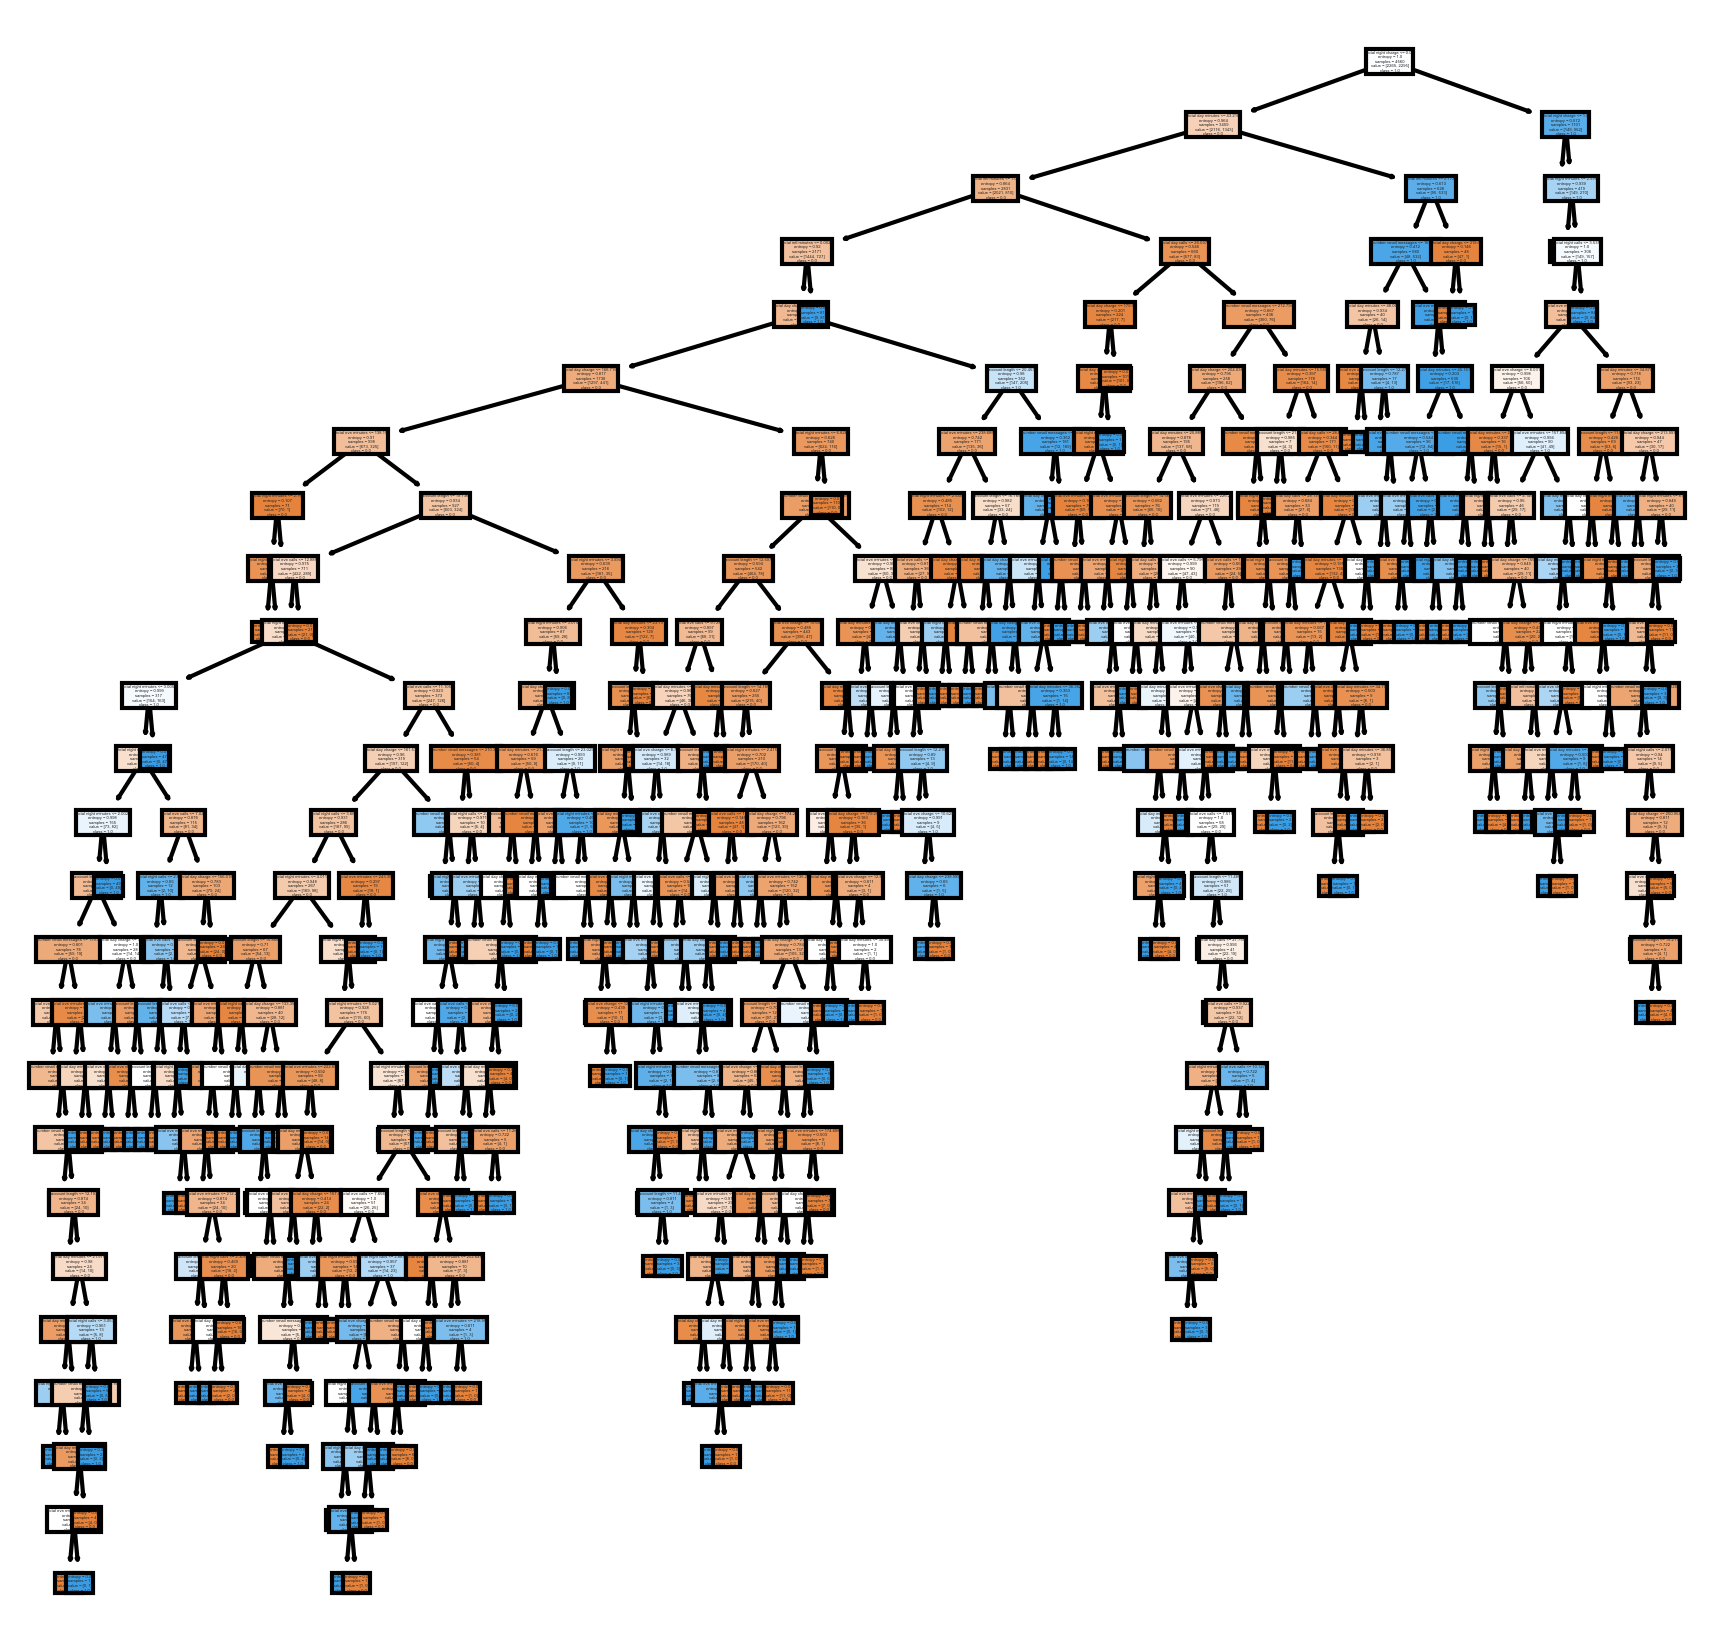

In [62]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (7,7), dpi=300)
tree.plot_tree(clf,
               feature_names = df.columns.drop('churn_True'), 
               class_names=np.unique(y).astype('str'),
               filled = True)
plt.show()

In [90]:
# print('Accuracy: ', accuracy_score(y_test, X_test))

#### Tuning Decision Tree

In [65]:
# Create X and y 
y = df['churn_True']
X = df.drop(columns=['churn_True'], axis=1)

# Split into training and test sets
SEED = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [66]:
# Train the classifier using training data 
dt = DecisionTreeClassifier(criterion='entropy', random_state=SEED)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [67]:
# Make predictions using test set 
y_pred = dt.predict(X_test)

# Check the AUC of predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8287961282516637

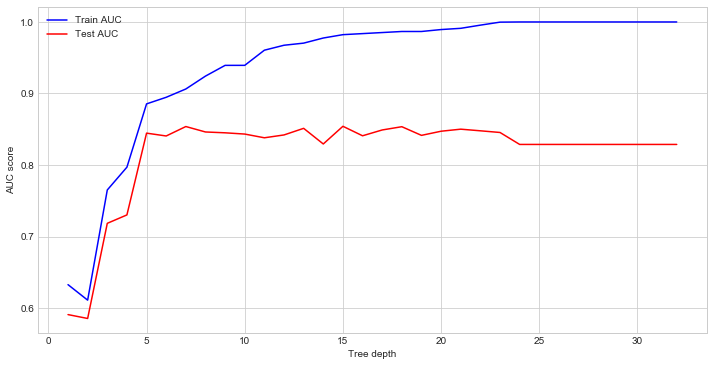

In [68]:
# Identify the optimal tree depth for given data
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=SEED)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results, 'b', label='Train AUC')
plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.legend()
plt.show()

Training and testing errors peak together at a tree depth of 5. After that, test error plateaus with close to no improvement.

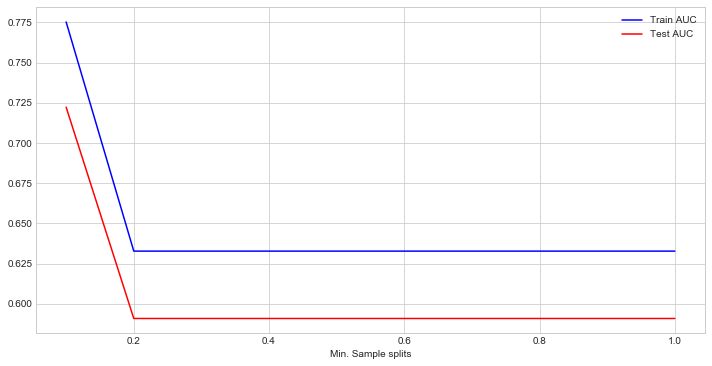

In [69]:
# Identify the optimal min-samples-split for given data
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=min_samples_split, random_state=SEED)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.xlabel('Min. Sample splits')
plt.legend()
plt.show()

AUC for both test and train data stabilize at (0.2). If minimum sampling split were to increase at all, there wouldn't be any improved learning.

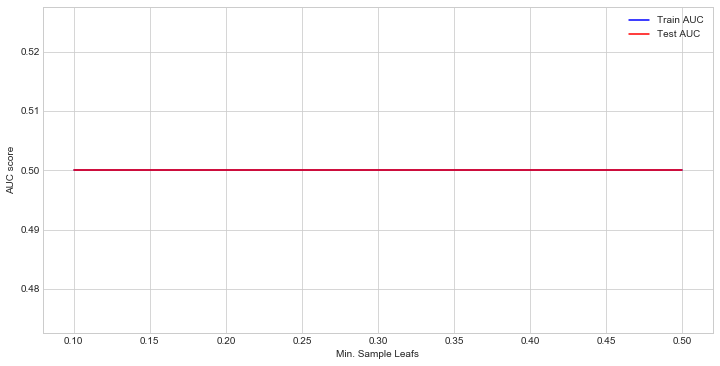

In [70]:
# Calculate the optimal value for minimum sample leafs
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=min_samples_leaf, random_state=SEED)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
plt.figure(figsize=(12,6))    
plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Min. Sample Leafs')
plt.legend()
plt.show()

Looks as though AUC has the best value for both train and test sets at (0.5)

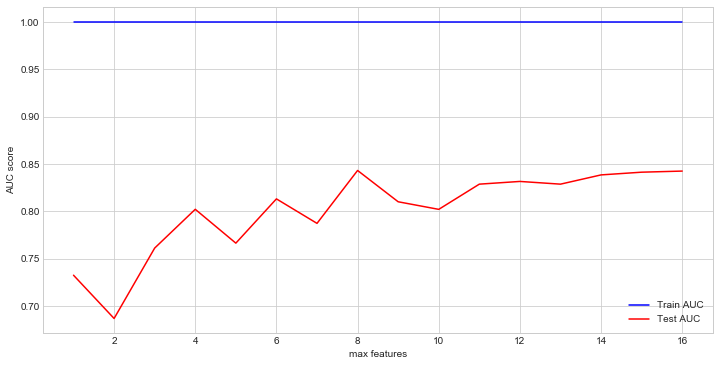

In [71]:
# Find the best value for optimal maximum feature size
max_features = list(range(1, X_train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
   dt = DecisionTreeClassifier(criterion='entropy', max_features=max_feature, random_state=SEED)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_features, train_results, 'b', label='Train AUC')
plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.legend()
plt.show()

Training set has no effect - flat AUC. Test set has fluctuation increasing to a max of eight features before plateauing. 

In [72]:
# Train a classifier with optimal values identified above
dt = DecisionTreeClassifier(criterion='entropy',
                           max_features=8,
                           max_depth=5,
                           min_samples_split=0.2,
                           min_samples_leaf=0.5, 
                           random_state=SEED)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5

AUC decreased from initial review before tuning. With that being said, Decision Tree model may not be an ideal model for our features that are mostly continuous rather than categorical.

### Random Forest

In [73]:
df.head()

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,international plan_yes,voice mail plan_yes,churn_True
state,,,,,,,,,,,,,,,,,,
KS,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0.0,1.0,0.0
OH,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0.0,1.0,0.0
NJ,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0.0,0.0,0.0
OH,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,1.0,0.0,0.0
OK,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,1.0,0.0,0.0


In [74]:
target = df['churn_True']
feats = df.drop('churn_True', axis=1)

In [75]:
feats.dtypes

account length              int64
number vmail messages       int64
total day minutes         float64
total day calls             int64
total day charge          float64
total eve minutes         float64
total eve calls             int64
total eve charge          float64
total night minutes       float64
total night calls           int64
total night charge        float64
total intl minutes        float64
total intl calls            int64
total intl charge         float64
customer service calls      int64
international plan_yes    float64
voice mail plan_yes       float64
dtype: object

In [76]:
data_train, data_test, target_train, target_test = train_test_split(df, target, 
                                                                    test_size = 0.25, random_state=123)

In [77]:
# Instantiate and fit a DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=5) 
tree_clf.fit(data_train, target_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [78]:
# Feature importance
tree_clf.feature_importances_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1.])

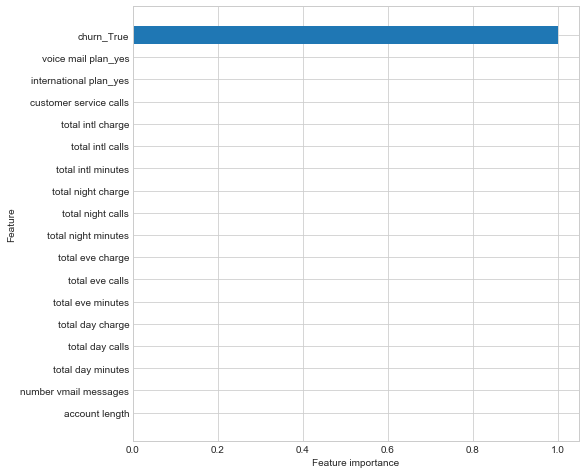

In [79]:
# Looking to see whih features have the most importance to the model.

def plot_feature_importances(model):
    n_features = data_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), data_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(tree_clf)

### XGBoost

In [81]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

In [82]:
D_train = xgb.DMatrix(X_train, label=Y_train)
D_test = xgb.DMatrix(X_test, label=Y_test)

In [83]:
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 3} 

steps = 20  # The number of training iterations

In [84]:
model = xgb.train(param, D_train, steps)

In [85]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(Y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(Y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(Y_test, best_preds)))

Precision = 0.9264005602240897
Recall = 0.8119790955048504
Accuracy = 0.9340329835082459


In [88]:
from sklearn.model_selection import GridSearchCV

clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 1, 2, 3],
     "min_child_weight" : [ 0.2, 0.4, 0.6, 0.8 ,1],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=3)

grid.fit(X_train, Y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_l...
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=4,
             param_grid={'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
                         'eta': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
                         'gamma': [0.0, 0